# Resample Data and Concatenate Channels

Informative as it is, raw Neon data is not always easy to work with. Different data streams (e.g., gaze, eye states, IMU) are sampled at different rates, don't necessarily share a common start timestamp, and within each stream data might not have been sampled at a constant rate. This tutorial demonstrates how to deal with these issues by resampling data streams and concatenating them into a single DataFrame.

We will use the same ``OfficeWalk`` dataset as in the [previous tutorial](read_recording.ipynb).

In [1]:
import numpy as np
from pyneon import get_sample_data, NeonRecording, time_to_ts

import matplotlib.pyplot as plt

recording_dir = get_sample_data("OfficeWalk") / "Timeseries Data" / "walk1-e116e606"

We can now access raw data from gaze, eye states, and IMU streams.

In [2]:
recording = NeonRecording(recording_dir)
gaze = recording.gaze
eye_states = recording.eye_states
imu = recording.imu

## Unequally sampled data

Data from each stream has `timestamp [ns]` and `time [s]` columns, which denotes the UTC time of the sample in nanoseconds and the relative time since stream onset in seconds, respectively. But are they equally spaced in time? Let's explore that by computing the time differences between consecutive samples for each stream and check how many unique values we have. If the data was sampled at a constant rate, we should have only one unique value.

In [3]:
# Get the data points
gaze_ts = gaze.data["timestamp [ns]"].values
eye_states_ts = eye_states.data["timestamp [ns]"].values
imu_ts = imu.data["timestamp [ns]"].values

# Calculate the distances between subsequent data points
gaze_diff = np.diff(gaze_ts)
eye_states_diff = np.diff(eye_states_ts)
imu_diff = np.diff(imu_ts)

# Unique values
gaze_diff_unique = np.unique(gaze_diff)
eye_states_diff_unique = np.unique(eye_states_diff)
imu_diff_unique = np.unique(imu_diff)

print(
    f"Unique gaze time differences: {len(gaze_diff_unique)}, max: {np.max(gaze_diff_unique)/1e6}ms"
)
print(
    f"Unique eye states time differences: {len(eye_states_diff_unique)}, max: {np.max(eye_states_diff_unique)/1e6}ms"
)
print(
    f"Unique imu time differences: {len(imu_diff_unique)}, max: {np.max(imu_diff_unique)/1e6}ms"
)

Unique gaze time differences: 130, max: 115.123ms
Unique eye states time differences: 130, max: 115.123ms
Unique imu time differences: 1106, max: 230.444ms


Oops, it seems the data are far from being continuously sampled. We can further explore the distribution of such differences by plotting a histogram.

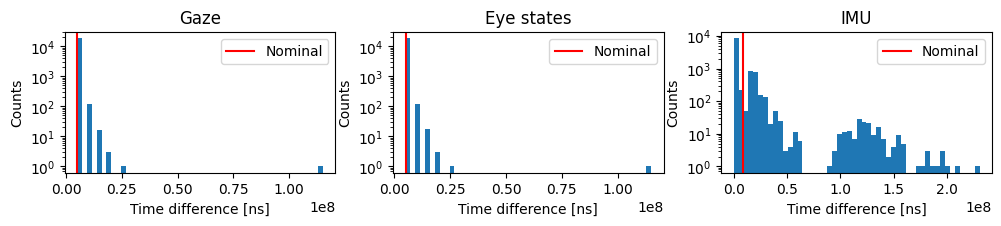

In [12]:
gaze_nominal_diff = 1e9 / gaze.sampling_freq_nominal
eye_states_nominal_diff = 1e9 / eye_states.sampling_freq_nominal
imu_nominal_diff = 1e9 / imu.sampling_freq_nominal

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
plt.tight_layout()

axs[0].hist(gaze_diff, bins=50)
axs[0].axvline(gaze_nominal_diff, color="red", label="Nominal")
axs[0].set_title("Gaze")

axs[1].hist(eye_states_diff, bins=50)
axs[1].axvline(eye_states_nominal_diff, color="red", label="Nominal")
axs[1].set_title("Eye states")

axs[2].hist(imu_diff, bins=50)
axs[2].axvline(imu_nominal_diff, color="red", label="Nominal")
axs[2].set_title("IMU")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_xlabel("Time difference [ns]")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

## Resampling data streams

Given the unequal sampling, if we want to obtain continuous data streams, interpolation is necessary. PyNeon uses the `scipy.interpolate.interp1d` function to interpolate data streams. We can resample each stream by simply calling `resample()` which returns a new DataFrame with the resampled data.

In [5]:
# Resample to the nominal sampling frequency
gaze_resampled_data = gaze.resample()
print(gaze_resampled_data.head())

ts = gaze_resampled_data["timestamp [ns]"].values
ts_diffs = np.diff(ts)
ts_diff_unique = np.unique(ts_diffs)
print(f"Only one unique time difference: {np.unique(ts_diffs)}")

        timestamp [ns]  time [s]  gaze x [px]  gaze y [px]  worn  fixation id  \
0  1725032224852161732     0.000  1067.486000   620.856000  True            1   
1  1725032224857161732     0.005  1066.920460   617.120037  True            1   
2  1725032224862161732     0.010  1072.698815   615.780043  True            1   
3  1725032224867161732     0.015  1067.446798   617.062049  True            1   
4  1725032224872161732     0.020  1071.563947   613.158050  True            1   

   blink id  azimuth [deg]  elevation [deg]  
0      <NA>      16.213030        -0.748998  
1      <NA>      16.176315        -0.511926  
2      <NA>      16.546402        -0.426620  
3      <NA>      16.210036        -0.508254  
4      <NA>      16.473517        -0.260391  
Only one unique time difference: [5000000]


In the above example, we resampled the gaze data with default parameters, which means that the resampled data will have the same start and timestamps as the original data, and the sampling rate is set to the nominal sampling frequency (200 Hz, as specified by Pupil Labs). Notice that resampling would not change the data type of the columns. For example, the `bool`-type `worn` column and the integer-type `fixation_id` column are preserved. 

Alternatively, one can also resample the gaze data to any desired timestamps by specifying the `new_ts` parameter. This is especially helpful when synchronizing different data streams. For example, we can resample the gaze data (~200Hz) to the timestamps of the IMU data (~110Hz).

In [6]:
print(f"Original gaze data length: {gaze.data.shape[0]}")
print(f"Original IMU data length: {imu.data.shape[0]}")
gaze_resampled_to_imu_data = gaze.resample(new_ts=imu.ts)
print(f"Data length after resampling to IMU: {gaze_resampled_to_imu_data.shape[0]}")

Original gaze data length: 18769
Original IMU data length: 10919
Data length after resampling to IMU: 10919


## Concatenating different streams

Based on the resampling method, it is then possible to concatenate different streams into a single DataFrame by resampling them to common timestamps. The method `concat_streams()` provides such functionality. It takes a list of stream names and resamples them to common timestamps, defined by the latest start and earliest end timestamps of the streams. The news ampling frequency can either be directly specified or taken from the lowest/highest sampling frequency of the streams.

In the following example, we will concatenate the gaze, eye states, and IMU streams into a single DataFrame using the default parameters (e.g., using the lowest sampling frequency of the streams).

In [7]:
concat_data = recording.concat_streams(["gaze", "eye_states", "imu"])
print(concat_data.head())

Concatenating streams:
	Gaze
	3D eye states
	IMU
Using lowest sampling rate: 110 Hz (['imu'])
Using latest start timestamp: 1725032224878547732 (['imu'])
Using earliest last timestamp: 1725032319533909732 (['imu'])
        timestamp [ns]  time [s]  gaze x [px]  gaze y [px]  worn  fixation id  \
0  1725032224878547732  0.000000  1073.410350   611.095861  True            1   
1  1725032224887638641  0.009091  1069.801082   613.382534  True            1   
2  1725032224896729550  0.018182  1070.090109   613.439696  True            1   
3  1725032224905820459  0.027273  1069.891351   612.921757  True            1   
4  1725032224914911368  0.036364  1069.692588   612.403804  True            1   

   blink id  azimuth [deg]  elevation [deg]  pupil diameter left [mm]  ...  \
0      <NA>      16.591703        -0.129540                  5.036588  ...   
1      <NA>      16.360605        -0.274666                  5.093205  ...   
2      <NA>      16.379116        -0.278283                  5.0

We show an exemplary sampling of eye, imu and concatenated data below. It can be seen that imu data has subsequent missing values which can in turn be interpolated

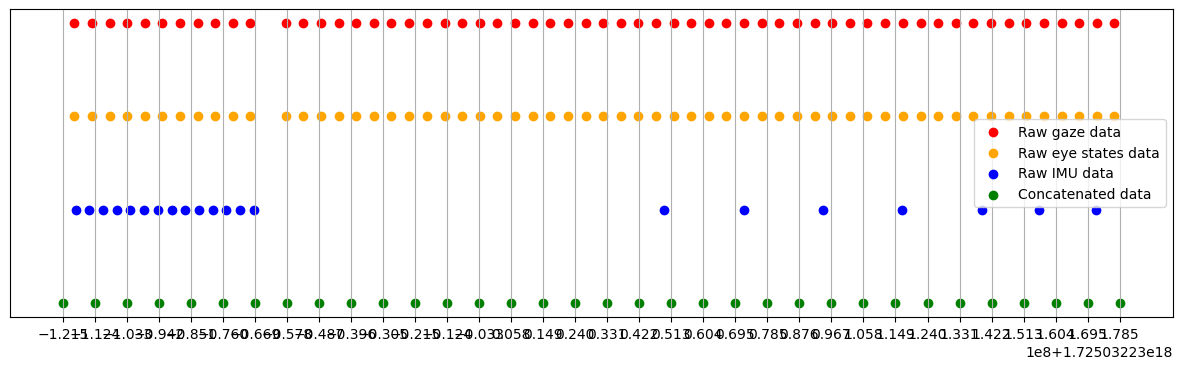

In [8]:
start_time = 5
end_time = 5.3
start_ts = time_to_ts(start_time, concat_data)
end_ts = time_to_ts(end_time, concat_data)

raw_gaze_data_slice = gaze.data[
    (gaze.data["timestamp [ns]"] >= start_ts) & (gaze.data["timestamp [ns]"] <= end_ts)
]
raw_eye_states_data_slice = eye_states.data[
    (eye_states.data["timestamp [ns]"] > start_ts)
    & (eye_states.data["timestamp [ns]"] <= end_ts)
]
raw_imu_data_slice = imu.data[
    (imu.data["timestamp [ns]"] >= start_ts) & (imu.data["timestamp [ns]"] <= end_ts)
]
concat_data_slice = concat_data[
    (concat_data["timestamp [ns]"] >= start_ts)
    & (concat_data["timestamp [ns]"] <= end_ts)
]

# plot all data in the same scatter plot
plt.figure(figsize=(15, 4))
plt.scatter(
    raw_gaze_data_slice["timestamp [ns]"],
    np.zeros_like(raw_gaze_data_slice["timestamp [ns]"]) + 2,
    label="Raw gaze data",
    color="red",
)
plt.scatter(
    raw_eye_states_data_slice["timestamp [ns]"],
    np.zeros_like(raw_eye_states_data_slice["timestamp [ns]"]) + 1,
    label="Raw eye states data",
    color="orange",
)
plt.scatter(
    raw_imu_data_slice["timestamp [ns]"],
    np.zeros_like(raw_imu_data_slice["timestamp [ns]"]),
    label="Raw IMU data",
    color="blue",
)
plt.scatter(
    concat_data_slice["timestamp [ns]"],
    np.zeros_like(concat_data_slice["timestamp [ns]"]) - 1,
    label="Concatenated data",
    color="green",
)
# set x-ticks with higher frequency and add gridlines
plt.xticks(concat_data_slice["timestamp [ns]"], labels=None)
plt.yticks([])
plt.grid()
plt.legend()

A linear interpolation allows us to estimate missing values. In the end, the concatenated dataframe combines all continuous data into one central location

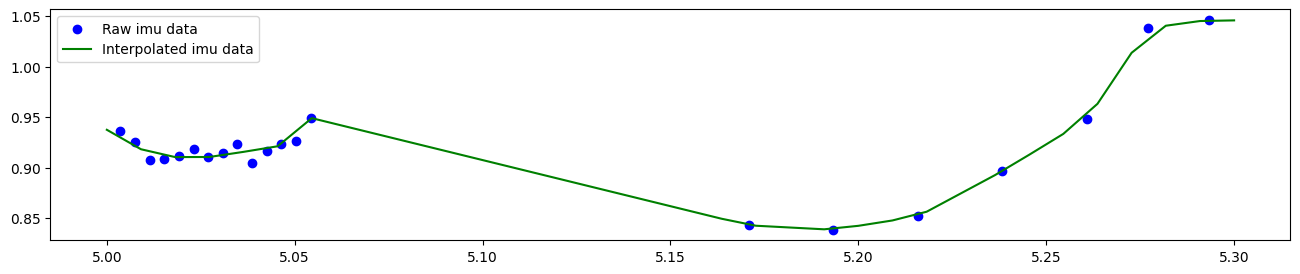

In [9]:
# plot imu data and interpolated data in same plot
plt.figure(figsize=(16, 3))
plt.scatter(
    raw_imu_data_slice["time [s]"],
    raw_imu_data_slice["acceleration z [g]"],
    label="Raw imu data",
    color="blue",
)
plt.plot(
    concat_data_slice["time [s]"],
    concat_data_slice["acceleration z [g]"],
    label="Interpolated imu data",
    color="green",
)
plt.legend()